In [2]:
import numpy as np
import netCDF4 as nc
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from datetime import datetime
import xarray as xr
# from mpl_toolkits.basemap import Basemap

# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.svm import SVR
from sklearn.cluster import KMeans
#others
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

In [3]:
base_dir = "../dataset"
# nc.Dataset(f"{base_dir}/")
df_locations = pd.read_csv(f"{base_dir}/SKNlocations.csv")
df_data = pd.read_excel(f"{base_dir}/FilledDataset2012.xlsx", sheet_name="Data_in")


ds_air2m = xr.open_dataset(f"{base_dir}/air.2m.mon.mean.regridded.nc")
ds_air1000_500 = xr.open_dataset(f"{base_dir}/air.1000-500.mon.mean.nc")
ds_hgt500 = xr.open_dataset(f"{base_dir}/hgt500.mon.mean.nc")
ds_hgt1000 = xr.open_dataset(f"{base_dir}/hgt1000.mon.mean.nc")
ds_omega500 = xr.open_dataset(f"{base_dir}/omega500.mon.mean.nc")
ds_pottemp_1000_500 = xr.open_dataset(f"{base_dir}/pottmp.1000-500.mon.mean.nc")
ds_pottemp_1000_850 = xr.open_dataset(f"{base_dir}/pottmp.1000-850.mon.mean.nc")
ds_pwtr = xr.open_dataset(f"{base_dir}/pwtr.mon.mean.nc")
ds_u700 = xr.open_dataset(f"{base_dir}/shum_x_uwnd.700.mon.mean.nc")
ds_u925 = xr.open_dataset(f"{base_dir}/shum_x_uwnd.925.mon.mean.nc")
ds_v700 = xr.open_dataset(f"{base_dir}/shum_x_vwnd.700.mon.mean.nc")
ds_v950 = xr.open_dataset(f"{base_dir}/shum_x_vwnd.925.mon.mean.nc")
ds_shum700 = xr.open_dataset(f"{base_dir}/shum700.mon.mean.nc")
ds_shum925 = xr.open_dataset(f"{base_dir}/shum925.mon.mean.nc")
ds_skt = xr.open_dataset(f"{base_dir}/skt.mon.mean.regridded.nc")
ds_slp = xr.open_dataset(f"{base_dir}/slp.mon.mean.nc")

# nc.Dataset(f"{base_dir}/")

In [3]:
# load all the 16 netcdf files
ds_entries = [
    ds_air2m,
    ds_air1000_500,
    ds_hgt500,
    ds_hgt1000,
    ds_omega500,
    ds_pottemp_1000_500,
    ds_pottemp_1000_850,
    ds_pwtr,
    ds_u700,
    ds_u925,
    ds_v700,
    ds_v950,
    ds_shum700,
    ds_shum925,
    ds_skt,
    ds_slp
]

In [4]:
# Make sure for all nectcf files, lat and lon are consistent and that
# lat = np.arange(90, -91, -2.5)
# lon = np.arange(0, 365, 2.5)
for entry in ds_entries:
    test_lat = entry["lat"] == np.arange(90, -91, -2.5)
    test_lon = entry["lon"] == np.arange(0, 360, 2.5)
    assert np.all(test_lat) == True
    assert np.all(test_lon) == True
lat = np.arange(90, -91, -2.5)
lon = np.arange(0, 365, 2.5)

## Where are all stations located?

In [5]:
df_locations = pd.read_csv(f"{base_dir}/SKNlocations.csv")
df_locations.head()

,SKN,Name,Lat_DD,Lon_DD
0,1.0,KALAE,18.916176,-155.674994
1,1.1,MORSE FIELD,18.913680,-155.680550
2,1.2,KALAE S TRK STA,18.938669,-155.680549
3,2.0,MANUKA,19.108660,-155.825545
4,2.1,KAHUKU MAUKA 2.10,19.108890,-155.746670


In [6]:
# lat_hawaii = [17.5, 20, 22.5]
lat_hawaii = [15, 17.5, 20, 22.5, 25]
# lon_hawaii = [-160, -157.5, -155]
lon_hawaii = [-162.5, -160, -157.5, -155, -152.5]
xx, yy = np.meshgrid(lon_hawaii, lat_hawaii)

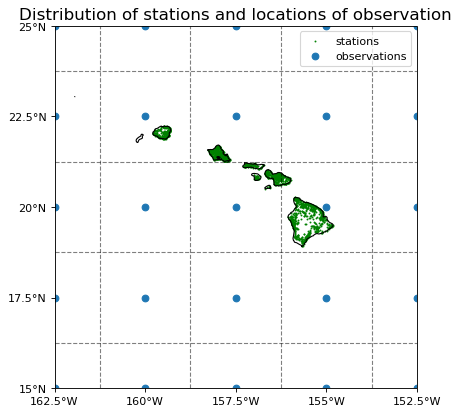

In [7]:
plt.figure(figsize=(10, 6), dpi=80)

ax = plt.axes(projection=ccrs.PlateCarree())

xmin, xmax = -162.5, -152.5
ymin, ymax = 15, 25

# ax.set_xticks([-162.5, -160, -157.5, -155])
# ax.set_yticks([17.5, 20, 22.5])

ax.set_xticks(np.arange(xmin, xmax+1, 2.5))
ax.set_yticks(np.arange(ymin, ymax+1, 2.5))

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)


# data_matrix_interp.plot()
# data_matrix.plot()

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.grid(linewidth=2, color='black', linestyle='--')

stations = plt.scatter(df_locations["Lon_DD"], df_locations["Lat_DD"], s=0.5, marker='o', color="green", label="stations")
observations = plt.scatter(xx, yy, label="observations")
plt.vlines(x=np.arange(xmin, xmax+1, 2.5) - 1.25, ymin=ymin, ymax=ymax, color="k", linewidth=1, linestyle="--", alpha=0.5)
plt.hlines(y=np.arange(ymin, ymax+1, 2.5) - 1.25 , xmin=xmin, xmax=xmax, color="k", linewidth=1, linestyle="--", alpha=0.5)
plt.title("Distribution of stations and locations of observation", fontsize=(15))
plt.legend()
ax.coastlines(resolution='10m')
print()

## Single Closest Observation vs. Bilinear Interpolation

In [15]:
data_matrix = ds_air2m.loc[dict(time="1948-06-01", lon=np.array(lon_hawaii) + 360, lat=lat_hawaii)]["air"]

data_matrix_interp_linear = data_matrix.interp(
    lat=np.linspace(lat_hawaii[0],
                    lat_hawaii[-1],
                    100
                   ),
    lon=np.linspace(lon_hawaii[0],
                    lon_hawaii[-1],
                    100
    ) + 360,
    method="linear"
)

data_matrix_interp_cubic = data_matrix.interp(
    lat=np.linspace(lat_hawaii[0],
                    lat_hawaii[-1],
                    100
                   ),
    lon=np.linspace(lon_hawaii[0],
                    lon_hawaii[-1],
                    100
    ) + 360,
    method="cubic"
)
# data_matrix_interp.plot()

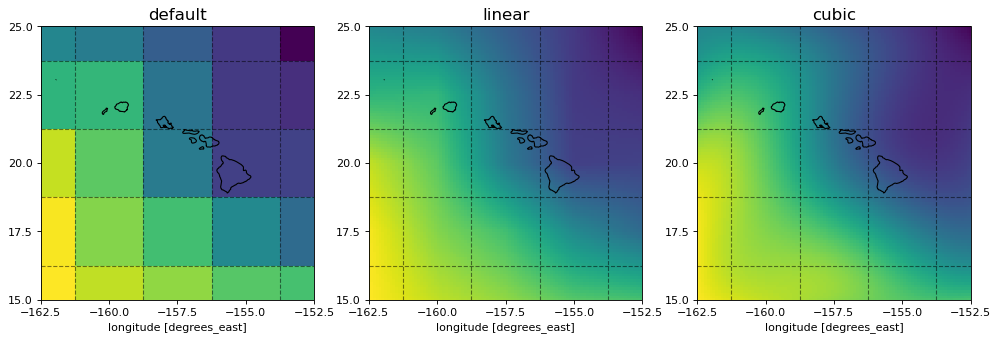

In [29]:
fig, axs = plt.subplots(
    1, 3, figsize=(15, 6), dpi=80,
    subplot_kw={'projection': ccrs.PlateCarree()},
)

xmin, xmax = -162.5, -152.5
ymin, ymax = 15, 25

data_matrix.plot(ax=axs[0], add_colorbar=False)
data_matrix_interp_linear.plot(ax=axs[1], add_colorbar=False)
data_matrix_interp_cubic.plot(ax=axs[2], add_colorbar=False)

for ax in axs:
    #ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_xticks(np.arange(xmin, xmax+1, 2.5))
    ax.set_yticks(np.arange(ymin, ymax+1, 2.5))
    ax.set_ylabel("")

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.coastlines(resolution='10m')
    #ax.xaxis.set_major_formatter(lon_formatter)
    #ax.yaxis.set_major_formatter(lat_formatter)
    ax.grid(linewidth=2, color='black', linestyle='--')
    ax.vlines(x=np.arange(xmin, xmax+1, 2.5) - 1.25, ymin=ymin, ymax=ymax, color="k", linewidth=1, linestyle="--", alpha=0.5)
    ax.hlines(y=np.arange(ymin, ymax+1, 2.5) - 1.25 , xmin=xmin, xmax=xmax, color="k", linewidth=1, linestyle="--", alpha=0.5)
    #lon_formatter = cticker.LongitudeFormatter()
    #lat_formatter = cticker.LatitudeFormatter()



    #stations = ax.scatter(df_locations["Lon_DD"], df_locations["Lat_DD"], s=0.5, marker='o', color="green", label="stations")
    #observations = ax.scatter(xx, yy, label="observations")
    # ax.legend()
axs[0].set_title("default", fontsize=(15))
axs[1].set_title("linear", fontsize=(15))
axs[2].set_title("cubic", fontsize=(15))


print()

In [10]:
data_matrix = ds_air2m.loc[dict(time="1948-06-01", lon=np.array(lon_hawaii) + 360, lat=lat_hawaii)]["air"]

data_matrix_interp_linear = data_matrix.interp(
    lat=np.linspace(lat_hawaii[0],
                    lat_hawaii[-1],
                    100
                   ),
    lon=np.linspace(lon_hawaii[0],
                    lon_hawaii[-1],
                    100
    ) + 360,
    method="linear"
).sel(lat=22.10021, lon=206.331, method="nearest")

## Other stuff

In [93]:
max(df_data["Year"])

2012

In [9]:
for entry in ds_entries:
    print(max(entry["time"][:]))

<xarray.DataArray 'time' ()>
array('2019-08-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2019-08-01
Attributes:
    standard_name:  time
    long_name:      Time
    axis:           T
<xarray.DataArray 'time' ()>
array('2019-08-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2019-08-01
Attributes:
    standard_name:  time
    long_name:      Time
    axis:           T
<xarray.DataArray 'time' ()>
array('2017-12-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2017-12-01
Attributes:
    long_name:        Time
    delta_t:          0000-01-00 00:00:00
    avg_period:       0000-01-00 00:00:00
    prev_avg_period:  0000-00-01 00:00:00
    standard_name:    time
    axis:             T
    actual_range:     [1297320. 1910208.]
<xarray.DataArray 'time' ()>
array('2017-12-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2017-12-0

In [12]:
# Make sure for all nectcf files, lat and lon are consistent and that
# lat = np.arange(90, -91, -2.5)
# lon = np.arange(0, 365, 2.5)
for entry in ds_entries:
    test_lat = entry["lat"] == np.arange(90, -91, -2.5)
    test_lon = entry["lon"] == np.arange(0, 360, 2.5)
    assert np.all(test_lat) == True
    assert np.all(test_lon) == True

In [31]:
ds = xr.open_dataset(f"{base_dir}/air.2m.mon.mean.regridded.nc")

In [31]:
df = ds.to_dataframe().reorder_levels(["time", "lat", "lon"])

In [30]:
dataset = nc.MFDataset([
    f"{base_dir}/air.2m.mon.mean.regridded.nc",
    f"{base_dir}/air.1000-500.mon.mean.nc",
    f"{base_dir}/hgt500.mon.mean.nc",
    f"{base_dir}/hgt1000.mon.mean.nc",
    f"{base_dir}/omega500.mon.mean.nc",
    f"{base_dir}/pottmp.1000-500.mon.mean.nc",
    f"{base_dir}/pottmp.1000-850.mon.mean.nc",
    f"{base_dir}/pwtr.mon.mean.nc",
    f"{base_dir}/shum_x_uwnd.700.mon.mean.nc",
    f"{base_dir}/shum_x_uwnd.925.mon.mean.nc",
    f"{base_dir}/shum_x_vwnd.700.mon.mean.nc",
    f"{base_dir}/shum_x_vwnd.925.mon.mean.nc",
    f"{base_dir}/shum700.mon.mean.nc",
    f"{base_dir}/shum925.mon.mean.nc",
    f"{base_dir}/skt.mon.mean.regridded.nc",
    f"{base_dir}/slp.mon.mean.nc",
])

KeyError: 'air'

In [ ]:
base_dir = "../dataset"


# nc.Dataset(f"{base_dir}/")